In [1]:
import torch
import torch.nn as nn
from torchinfo import summary

import copy
import os
import time
import numpy as np
import random

In [2]:
def print_size_of_model(model):
    """
    Print the size of the model.
    """
    torch.save(model.state_dict(), "temp.p")
    size_in_bytes = os.path.getsize("temp.p")
    if size_in_bytes < 1048576:
        size_in_kb = size_in_bytes / 1024
        print("{:.3f} KB".format(size_in_kb))
    else:
        size_in_mb = size_in_bytes / 1048576
        print("{:.3f} MB".format(size_in_mb))
    os.remove('temp.p')


def measure_inference_latency(model, input_shape, device = None, repetitions=100, warmup_it = 10):
    """
    Measures the inference time of the provided neural network model.

    Args:
        model: The neural network model to evaluate.
        input_shape: The shape of the input data expected by the model.

    Returns:
        tuple: A tuple containing the mean and standard deviation of the inference time
               measured in milliseconds.
    """
    if device is None:
        device = next(model.parameters()).device.type  # Get the device where the model is located
    
    dummy_input = torch.randn(1, *input_shape, dtype=torch.float).to(device)
    
    # Set model to evaluation mode
    model.to(device)
    model.eval()
    
    # GPU warm-up
    for _ in range(warmup_it):
        _ = model(dummy_input)

    # Measure inference time
    timings = []
    with torch.no_grad():
        if device == 'cuda':
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            for rep in range(repetitions):
                starter.record()
                _ = model(dummy_input)
                ender.record()
                torch.cuda.synchronize()
                curr_time = starter.elapsed_time(ender)
                timings.append(curr_time)
        else:  # CPU
            for rep in range(repetitions):
                start_time = time.time()
                _ = model(dummy_input)
                end_time = time.time()
                elapsed_time = (end_time - start_time) * 1000.0  # Convert to milliseconds
                timings.append(elapsed_time)

    # Calculate mean and std
    mean_time = np.mean(timings)
    std_time = np.std(timings)

    return mean_time, std_time


def model_equivalence(model_1, model_2, device, rtol=1e-05, atol=1e-08, num_tests=100, input_size=(1,3,32,32), verbose=False):
    """
    Tests whether two models are equivalent by comparing their outputs on random inputs.
    """

    model_1.to(device)
    model_2.to(device)

    for i in range(num_tests):
        print(f"Running test {i+1}/{num_tests}") if verbose else None
        x = torch.rand(size=input_size).to(device)
        y1 = model_1(x).detach().cpu().numpy()
        y2 = model_2(x).detach().cpu().numpy()
        print("Difference: ", np.max(np.abs(y1-y2))) if verbose else None
        if np.allclose(a=y1, b=y2, rtol=rtol, atol=atol, equal_nan=False) == False:
            print("Model equivalence test sample failed: ")
            print(y1)
            print(y2)
            return False
    print("Model equivalence test passed!")
    return True

def set_random_seeds(random_seed=0):
    """
    Set all random seeds to a fixed value to make results reproducible.
    """

    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

# Quantization
Original PhiNet definition not quantizable:

In [3]:
from micromind import PhiNet

model = PhiNet(input_shape = [3, 224, 224], num_layers = 7, alpha = 3, beta = 0.75,t_zero = 6.0, include_top= True, num_classes = 10)
print(model)

PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
        (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): DepthwiseConv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Con

## PhiNet Convolutional Block 1
First of two versions of PhiNet's convolutional blocks. In this case, the depth-wise convolutional block is defined as follows:

```python
DepthwiseConv2d(ch, ch, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1357, bias=False)
```

In [4]:
block1 = model._layers[6]
print(block1)

PhiNetConvBlock(
  (_layers): ModuleList(
    (0): Conv2d(144, 740, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(740, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): HSwish()
    (3): Dropout2d(p=0.05, inplace=False)
    (4): DepthwiseConv2d(740, 740, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=740, bias=False)
    (5): BatchNorm2d(740, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (6): HSwish()
    (7): SEBlock(
      (se_conv): Conv2d(740, 123, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (se_conv2): Conv2d(123, 740, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (activation): HSwish()
    )
    (8): Conv2d(740, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (9): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)


Definition of the original PhiNet convolutional block 1:

In [5]:
class PhiNetConv1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pointconv1 = nn.Sequential(
                nn.Conv2d(144, 740, kernel_size=1, bias=False),
                nn.BatchNorm2d(740, eps=1e-3, momentum=0.999),    
                torch.nn.Hardswish(inplace=True),
            )
        self.drop = nn.Dropout2d(p=0.05)
        self.depthwise = nn.Sequential(
                nn.Conv2d(740,740,kernel_size=3,stride=1,padding=1,groups=740,bias=False),
                nn.BatchNorm2d(740, eps=1e-3, momentum=0.999),
                torch.nn.Hardswish(inplace=True),
        )
        self.se = torch.nn.Sequential(
                nn.Conv2d(740, 123, kernel_size=1, stride=1, bias=False),
                nn.Conv2d(123, 740, kernel_size=1, stride=1, bias=False),
                torch.nn.Hardswish(inplace=True),
        )
        self.pointconv2 = nn.Sequential(
                nn.Conv2d(740, 144, kernel_size=1, bias=False),
                nn.BatchNorm2d(144, eps=1e-3, momentum=0.999),
        )

    def forward(self, x):

        x = self.pointconv1(x)
        x = self.drop(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.pointconv2(x)

        return x
    
test = PhiNetConv1()
print("Defined Block")
print(test)
print("Orginal BLock")
print(block1)

Defined Block
PhiNetConv1(
  (pointconv1): Sequential(
    (0): Conv2d(144, 740, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(740, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(740, 740, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=740, bias=False)
    (1): BatchNorm2d(740, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(740, 123, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(123, 740, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(740, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)
Orginal BLock
PhiNetConvBlock(
  (_layers): ModuleList(
    (0): Conv2d(144, 

Quantization of the original convolutional block 1 of PhiNet:

In [6]:
set_random_seeds(random_seed=0)

# Create the model to be quantized
Conv1_fp32 = PhiNetConv1().to("cpu")

# Create a copy of the model for fusion
Conv1_fp32_fused = copy.deepcopy(Conv1_fp32)

# Set the models to eval mode (important for fusion)
Conv1_fp32.eval()
Conv1_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet Conv1 block
Conv1_fp32_fused = torch.ao.quantization.fuse_modules(Conv1_fp32_fused, [['pointconv1.0', 'pointconv1.1'], ['depthwise.0', 'depthwise.1'], ['pointconv2.0', 'pointconv2.1']])

print(f"Conv1_fp32:\n {Conv1_fp32}\n")
print(f"Conv1_fp32_fused:\n {Conv1_fp32_fused}\n")

# Check that the fused model is equivalent to the original model
assert model_equivalence(model_1=Conv1_fp32, model_2=Conv1_fp32_fused, device="cpu", rtol=5e-03, atol=5e-06, num_tests=100, input_size=(1,144,28,28)), "Fused model is not equivalent to the original model!"

# Insert stubs
Conv1_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  Conv1_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

Conv1_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(Conv1_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {Conv1_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,144, 28, 28)
    Conv1_int8(x)

# Convert the observed model to a quantized model.
Conv1_int8 = torch.ao.quantization.convert(Conv1_int8, inplace=True)

print(f"Conv1_int8: \n {Conv1_int8}\n")

# run the model, relevant calculations will happen in int8
res = Conv1_int8(x)

Conv1_fp32:
 PhiNetConv1(
  (pointconv1): Sequential(
    (0): Conv2d(144, 740, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(740, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(740, 740, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=740, bias=False)
    (1): BatchNorm2d(740, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(740, 123, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(123, 740, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(740, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)

Conv1_fp32_fused:
 PhiNetConv1(
  (pointconv1): Sequential(
    (0): Conv2d(1

/home/matteotremonti/anaconda3/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Conv1_int8: 
 Sequential(
  (0): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (1): PhiNetConv1(
    (pointconv1): Sequential(
      (0): QuantizedConv2d(144, 740, kernel_size=(1, 1), stride=(1, 1), scale=0.020500173792243004, zero_point=68)
      (1): Identity()
      (2): QuantizedHardswish()
    )
    (drop): Dropout2d(p=0.05, inplace=False)
    (depthwise): Sequential(
      (0): QuantizedConv2d(740, 740, kernel_size=(3, 3), stride=(1, 1), scale=0.009569868445396423, zero_point=63, padding=(1, 1), groups=740)
      (1): Identity()
      (2): QuantizedHardswish()
    )
    (se): Sequential(
      (0): QuantizedConv2d(740, 123, kernel_size=(1, 1), stride=(1, 1), scale=0.0015119541203603148, zero_point=60, bias=False)
      (1): QuantizedConv2d(123, 740, kernel_size=(1, 1), stride=(1, 1), scale=0.0008994026575237513, zero_point=62, bias=False)
      (2): QuantizedHardswish()
    )
    (pointconv2): Sequential(
      (0): QuantizedConv2d(740, 144, kerne

Checking the size of FP32 and INT8 blocks:

In [7]:
print(f"FP32 size:")
print_size_of_model(Conv1_fp32)

print("INT8 size:")
print_size_of_model(Conv1_int8)

FP32 size:
1.563 MB
INT8 size:
445.729 KB


Checking the inference time of FP32 and INT8 blocks:

In [8]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv1_fp32, device ="cpu", input_shape=(144, 28, 28))
int8_cpu_inference_latency  = measure_inference_latency(Conv1_int8, device ="cpu", input_shape=(144, 28, 28))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 2.507 ms
INT8 CPU Inference Latency: 20.028 ms


Looking at the dimensions of both the FP32 and INT8 models, the INT8 is indeed more compact in size, as expected. However, contrary to what the documentation suggests, the INT8 model has slower inference times compared to the original FP32 model. The documentation indicated an expected reduction in inference time of about half.

### Modification of PhiNet original convolutional block 1

One of the problems could be that the number of channels is not divisible by 8. Therefore, we modify the convolutional block by making the channels divisible by 8:

In [9]:
class PhiNetConv1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pointconv1 = nn.Sequential(
                nn.Conv2d(144, 744, kernel_size=1, bias=False),
                nn.BatchNorm2d(744, eps=1e-3, momentum=0.999),    
                torch.nn.Hardswish(inplace=True),
            )
        self.drop = nn.Dropout2d(p=0.05)
        self.depthwise = nn.Sequential(
                nn.Conv2d(744,744,kernel_size=3,stride=1,padding=1,groups=744,bias=False),
                nn.BatchNorm2d(744, eps=1e-3, momentum=0.999),
                torch.nn.Hardswish(inplace=True),
        )
        self.se = torch.nn.Sequential(
                nn.Conv2d(744, 123, kernel_size=1, stride=1, bias=False),
                nn.Conv2d(123, 744, kernel_size=1, stride=1, bias=False),
                torch.nn.Hardswish(inplace=True),
        )
        self.pointconv2 = nn.Sequential(
                nn.Conv2d(744, 144, kernel_size=1, bias=False),
                nn.BatchNorm2d(144, eps=1e-3, momentum=0.999),
        )

    def forward(self, x):

        x = self.pointconv1(x)
        x = self.drop(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.pointconv2(x)

        return x
    
test = PhiNetConv1()
print("Defined Block")
print(test)
print("Orginal BLock")
print(block1)

Defined Block
PhiNetConv1(
  (pointconv1): Sequential(
    (0): Conv2d(144, 744, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(744, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(744, 744, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=744, bias=False)
    (1): BatchNorm2d(744, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(744, 123, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(123, 744, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(744, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)
Orginal BLock
PhiNetConvBlock(
  (_layers): ModuleList(
    (0): Conv2d(144, 

In [10]:
set_random_seeds(random_seed=0)

# Create the model to be quantized
Conv1_fp32 = PhiNetConv1().to("cpu")

# Create a copy of the model for fusion
Conv1_fp32_fused = copy.deepcopy(Conv1_fp32)

# Set the models to eval mode (important for fusion)
Conv1_fp32.eval()
Conv1_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet Conv1 block
Conv1_fp32_fused = torch.ao.quantization.fuse_modules(Conv1_fp32_fused, [['pointconv1.0', 'pointconv1.1'], ['depthwise.0', 'depthwise.1'], ['pointconv2.0', 'pointconv2.1']])

print(f"Conv1_fp32:\n {Conv1_fp32}\n")
print(f"Conv1_fp32_fused:\n {Conv1_fp32_fused}\n")

# Check that the fused model is equivalent to the original model
assert model_equivalence(model_1=Conv1_fp32, model_2=Conv1_fp32_fused, device="cpu", rtol=5e-03, atol=5e-06, num_tests=100, input_size=(1,144,28,28)), "Fused model is not equivalent to the original model!"

# Insert stubs
Conv1_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  Conv1_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

Conv1_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(Conv1_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {Conv1_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,144, 28, 28)
    Conv1_int8(x)

# Convert the observed model to a quantized model.
Conv1_int8 = torch.ao.quantization.convert(Conv1_int8, inplace=True)

print(f"Conv1_int8: \n {Conv1_int8}\n")

# run the model, relevant calculations will happen in int8
res = Conv1_int8(x)

Conv1_fp32:
 PhiNetConv1(
  (pointconv1): Sequential(
    (0): Conv2d(144, 744, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(744, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(744, 744, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=744, bias=False)
    (1): BatchNorm2d(744, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(744, 123, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(123, 744, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(744, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)

Conv1_fp32_fused:
 PhiNetConv1(
  (pointconv1): Sequential(
    (0): Conv2d(1

In [11]:
print("FP32 size:")
print_size_of_model(Conv1_fp32)

print("INT8 size:")
print_size_of_model(Conv1_int8)

FP32 size:
1.571 MB
INT8 size:
447.729 KB


In [12]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv1_fp32, device ="cpu", input_shape=(144, 28, 28))
int8_cpu_inference_latency  = measure_inference_latency(Conv1_int8, device ="cpu", input_shape=(144, 28, 28))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 3.327 ms
INT8 CPU Inference Latency: 1.829 ms


In [13]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv1_fp32, device ="cpu", input_shape=(144, 224, 224))
int8_cpu_inference_latency  = measure_inference_latency(Conv1_int8, device ="cpu", input_shape=(144, 224, 224))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 329.104 ms
INT8 CPU Inference Latency: 110.272 ms


As expected, after the number of channels has been made divisible by 8, the model in INT8 is smaller in terms of memory. In contrast to the original block, the inference time is also reduced, with the reduction increasing as the input resolution increases.

## PhiNet Convolutional Block 2

Second versions of PhiNet's convolutional blocks. In this case, the depth-wise convolutional block is defined as follows:

```python
DepthwiseConv2d(ch, ch, kernel_size=(3, 3), stride=(2, 2), groups=ch, bias=False)
```
Diffrently from the PhiNet Convolutional Block 1, here we have ` stride=(2, 2)` and `padding = 0`. Moreover, before the `Dropout2d(p=0.05)` it is inserted the following layer:

```python 
ZeroPad2d((1, 1, 1, 1))
```

In [14]:
block2 = model._layers[7]
print(block2)

PhiNetConvBlock(
  (_layers): ModuleList(
    (0): Conv2d(144, 709, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(709, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): HSwish()
    (3): ZeroPad2d((1, 1, 1, 1))
    (4): Dropout2d(p=0.05, inplace=False)
    (5): DepthwiseConv2d(709, 709, kernel_size=(3, 3), stride=(2, 2), groups=709, bias=False)
    (6): BatchNorm2d(709, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (7): HSwish()
    (8): SEBlock(
      (se_conv): Conv2d(709, 118, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (se_conv2): Conv2d(118, 709, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (activation): HSwish()
    )
    (9): Conv2d(709, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): BatchNorm2d(288, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)


Definition of the original PhiNet convolutional block 2:

In [15]:
class PhiNetConv2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pointconv1 = nn.Sequential(
                nn.Conv2d(144, 709, kernel_size=1, bias=False),
                nn.BatchNorm2d(709, eps=1e-3, momentum=0.999),    
                torch.nn.Hardswish(inplace=True),
            )
        self.pad = nn.ZeroPad2d(1)
        self.drop = nn.Dropout2d(p=0.05)
        self.depthwise = nn.Sequential(
                nn.Conv2d(709,709,kernel_size=3,stride=2,padding=0,groups=709,bias=False),
                nn.BatchNorm2d(709, eps=1e-3, momentum=0.999),
                torch.nn.Hardswish(inplace=True),
        )
        self.se = torch.nn.Sequential(
                nn.Conv2d(709, 118, kernel_size=1, stride=1, bias=False),
                nn.Conv2d(118, 709, kernel_size=1, stride=1, bias=False),
                torch.nn.Hardswish(inplace=True),
        )
        self.pointconv2 = nn.Sequential(
                nn.Conv2d(709, 288, kernel_size=1, bias=False),
                nn.BatchNorm2d(288, eps=1e-3, momentum=0.999),
        )

    def forward(self, x):

        x = self.pointconv1(x)
        x = self.pad(x)
        x = self.drop(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.pointconv2(x)

        return x
    
test = PhiNetConv2()
print("Defined Block")
print(test)
print("Orginal BLock")
print(block2)

Defined Block
PhiNetConv2(
  (pointconv1): Sequential(
    (0): Conv2d(144, 709, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(709, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (pad): ZeroPad2d((1, 1, 1, 1))
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(709, 709, kernel_size=(3, 3), stride=(2, 2), groups=709, bias=False)
    (1): BatchNorm2d(709, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(709, 118, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(118, 709, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(709, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(288, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)
Orginal BLock
PhiNetConvBlock(
  (_layers): ModuleList(
    

Quantization of the original convolutional block 2 of PhiNet:

In [16]:
set_random_seeds(random_seed=0)

# Create the model to be quantized
Conv2_fp32 = PhiNetConv2().to("cpu")

# Create a copy of the model for fusion
Conv2_fp32_fused = copy.deepcopy(Conv2_fp32)

# Set the models to eval mode (important for fusion)
Conv2_fp32.eval()
Conv2_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet Conv1 block
Conv2_fp32_fused = torch.ao.quantization.fuse_modules(Conv2_fp32_fused, [['pointconv1.0', 'pointconv1.1'], ['depthwise.0', 'depthwise.1'], ['pointconv2.0', 'pointconv2.1']])

print(f"Conv2_fp32:\n {Conv2_fp32}\n")
print(f"Conv2_fp32_fused:\n {Conv2_fp32_fused}\n")

# Check that the fused model is equivalent to the original model
assert model_equivalence(model_1=Conv2_fp32, model_2=Conv2_fp32_fused, device="cpu", rtol=5e-03, atol=5e-06, num_tests=100, input_size=(1,144,28,28)), "Fused model is not equivalent to the original model!"

# Insert stubs
Conv2_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  Conv2_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

Conv2_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(Conv2_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {Conv2_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,144, 28, 28)
    Conv2_int8(x)

# Convert the observed model to a quantized model.
Conv2_int8 = torch.ao.quantization.convert(Conv2_int8, inplace=True)

print(f"Conv2_int8: \n {Conv2_int8}\n")

# run the model, relevant calculations will happen in int8
res = Conv2_int8(x)

Conv2_fp32:
 PhiNetConv2(
  (pointconv1): Sequential(
    (0): Conv2d(144, 709, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(709, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (pad): ZeroPad2d((1, 1, 1, 1))
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(709, 709, kernel_size=(3, 3), stride=(2, 2), groups=709, bias=False)
    (1): BatchNorm2d(709, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(709, 118, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(118, 709, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(709, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(288, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)

Conv2_fp32_fused:
 PhiNetConv2(
  (pointconv1): Sequential(


Checking the size of FP32 and INT8 blocks:

In [17]:
print("FP32 size:")
print_size_of_model(Conv2_fp32)

print("INT8 size:")
print_size_of_model(Conv2_int8)

FP32 size:
1.862 MB
INT8 size:
523.104 KB


Checking the inference time of FP32 and INT8 blocks:

In [18]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv2_fp32, device ="cpu", input_shape=(144, 28, 28))
int8_cpu_inference_latency  = measure_inference_latency(Conv2_int8, device ="cpu", input_shape=(144, 28, 28))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 1.905 ms
INT8 CPU Inference Latency: 5.255 ms


Looking at the dimensions of both the FP32 and INT8 models, the INT8 is indeed more compact in size, as expected. However, contrary to what the documentation suggests, the INT8 model has slower inference times compared to the original FP32 model. The documentation indicated an expected reduction in inference time of about half.

### Modification of PhiNet original convolutional block 2

One of the problems could be that the number of channels is not divisible by 8. Therefore, we modify the convolutional block by making the channels divisible by 8:

In [19]:
class PhiNetConv2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pointconv1 = nn.Sequential(
                nn.Conv2d(144, 712, kernel_size=1, bias=False),
                nn.BatchNorm2d(712, eps=1e-3, momentum=0.999),    
                torch.nn.Hardswish(inplace=True),
            )
        self.pad = nn.ZeroPad2d(1)
        self.drop = nn.Dropout2d(p=0.05)
        self.depthwise = nn.Sequential(
                nn.Conv2d(712,712,kernel_size=3,stride=2,padding=0,groups=712,bias=False),
                nn.BatchNorm2d(712, eps=1e-3, momentum=0.999),
                torch.nn.Hardswish(inplace=True),
        )
        self.se = torch.nn.Sequential(
                nn.Conv2d(712, 118, kernel_size=1, stride=1, bias=False),
                nn.Conv2d(118, 712, kernel_size=1, stride=1, bias=False),
                torch.nn.Hardswish(inplace=True),
        )
        self.pointconv2 = nn.Sequential(
                nn.Conv2d(712, 288, kernel_size=1, bias=False),
                nn.BatchNorm2d(288, eps=1e-3, momentum=0.999),
        )

    def forward(self, x):

        x = self.pointconv1(x)
        x = self.pad(x)
        x = self.drop(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.pointconv2(x)

        return x
    
test = PhiNetConv2()
print("Defined Block")
print(test)
print("Orginal BLock")
print(block2)

Defined Block
PhiNetConv2(
  (pointconv1): Sequential(
    (0): Conv2d(144, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (pad): ZeroPad2d((1, 1, 1, 1))
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(712, 712, kernel_size=(3, 3), stride=(2, 2), groups=712, bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(712, 118, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(118, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(712, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(288, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)
Orginal BLock
PhiNetConvBlock(
  (_layers): ModuleList(
    

In [20]:
set_random_seeds(random_seed=0)

# Create the model to be quantized
Conv2_fp32 = PhiNetConv2().to("cpu")

# Create a copy of the model for fusion
Conv2_fp32_fused = copy.deepcopy(Conv2_fp32)

# Set the models to eval mode (important for fusion)
Conv2_fp32.eval()
Conv2_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet Conv1 block
Conv2_fp32_fused = torch.ao.quantization.fuse_modules(Conv2_fp32_fused, [['pointconv1.0', 'pointconv1.1'], ['depthwise.0', 'depthwise.1'], ['pointconv2.0', 'pointconv2.1']])

print(f"Conv2_fp32:\n {Conv2_fp32}\n")
print(f"Conv2_fp32_fused:\n {Conv2_fp32_fused}\n")

# Check that the fused model is equivalent to the original model
assert model_equivalence(model_1=Conv2_fp32, model_2=Conv2_fp32_fused, device="cpu", rtol=5e-03, atol=5e-06, num_tests=100, input_size=(1,144,28,28)), "Fused model is not equivalent to the original model!"

# Insert stubs
Conv2_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  Conv2_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

Conv2_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(Conv2_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {Conv2_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,144, 28, 28)
    Conv2_int8(x)

# Convert the observed model to a quantized model.
Conv2_int8 = torch.ao.quantization.convert(Conv2_int8, inplace=True)

print(f"Conv2_int8: \n {Conv2_int8}\n")

# run the model, relevant calculations will happen in int8
res = Conv2_int8(x)

Conv2_fp32:
 PhiNetConv2(
  (pointconv1): Sequential(
    (0): Conv2d(144, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (pad): ZeroPad2d((1, 1, 1, 1))
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(712, 712, kernel_size=(3, 3), stride=(2, 2), groups=712, bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(712, 118, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(118, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(712, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(288, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)

Conv2_fp32_fused:
 PhiNetConv2(
  (pointconv1): Sequential(


In [21]:
print("FP32 size:")
print_size_of_model(Conv2_fp32)

print("INT8 size:")
print_size_of_model(Conv2_int8)

FP32 size:
1.870 MB
INT8 size:
524.979 KB


In [22]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv2_fp32, device ="cpu", input_shape=(144, 28, 28))
int8_cpu_inference_latency  = measure_inference_latency(Conv2_int8, device ="cpu", input_shape=(144, 28, 28))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 1.931 ms
INT8 CPU Inference Latency: 5.426 ms


Unlike the original convolutional block 1 of PhiNet. Making the channels divisible by 8 is not enough. In fact, the model in INT8 is inferior in terms of memomics but slower in terms of inference time.

### Modification of PhiNet original convolutional block 2 (V2)
The number of channels of the convolutional blocks is made divisible by 8 and `nn.ZeroPad2d(1)` is removed and placed inside the Depthwise Convolution using `Conv2d(padding = 1)`. The depth-wise convolution becomes:

```python
Conv2d(ch, ch, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=ch, bias=False)
```

In [23]:
# Define PhiNet Convolutional Block without number of channel divisible by 8
class PhiNetConv2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        self.pointconv1 = nn.Sequential(
                nn.Conv2d(144, 712, kernel_size=1, bias=False),
                nn.BatchNorm2d(712, eps=1e-3, momentum=0.999),    
                torch.nn.Hardswish(inplace=True),
            )
        self.drop = nn.Dropout2d(p=0.05)
        self.depthwise = nn.Sequential(
                nn.Conv2d(712,712,kernel_size=3,stride=2,padding=1,groups=712,bias=False),
                nn.BatchNorm2d(712, eps=1e-3, momentum=0.999),
                torch.nn.Hardswish(inplace=True),
        )
        self.se = torch.nn.Sequential(
                nn.Conv2d(712, 118, kernel_size=1, stride=1, bias=False),
                nn.Conv2d(118, 712, kernel_size=1, stride=1, bias=False),
                torch.nn.Hardswish(inplace=True),
        )
        self.pointconv2 = nn.Sequential(
                nn.Conv2d(712, 288, kernel_size=1, bias=False),
                nn.BatchNorm2d(288, eps=1e-3, momentum=0.999),
        )

    def forward(self, x):

        x = self.pointconv1(x)
        x = self.drop(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.pointconv2(x)

        return x
    
test = PhiNetConv2()
print("Defined Block")
print(test)
print("Orginal BLock")
print(block2)

Defined Block
PhiNetConv2(
  (pointconv1): Sequential(
    (0): Conv2d(144, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(712, 712, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=712, bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(712, 118, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(118, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(712, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(288, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)
Orginal BLock
PhiNetConvBlock(
  (_layers): ModuleList(
    (0): Conv2d(144, 

In [24]:
set_random_seeds(random_seed=0)

# Create the model to be quantized
Conv2_fp32 = PhiNetConv2().to("cpu")

# Create a copy of the model for fusion
Conv2_fp32_fused = copy.deepcopy(Conv2_fp32)

# Set the models to eval mode (important for fusion)
Conv2_fp32.eval()
Conv2_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet Conv1 block
Conv2_fp32_fused = torch.ao.quantization.fuse_modules(Conv2_fp32_fused, [['pointconv1.0', 'pointconv1.1'], ['depthwise.0', 'depthwise.1'], ['pointconv2.0', 'pointconv2.1']])

print(f"Conv2_fp32:\n {Conv2_fp32}\n")
print(f"Conv2_fp32_fused:\n {Conv2_fp32_fused}\n")

# Check that the fused model is equivalent to the original model
assert model_equivalence(model_1=Conv2_fp32, model_2=Conv2_fp32_fused, device="cpu", rtol=5e-03, atol=5e-06, num_tests=100, input_size=(1,144,28,28)), "Fused model is not equivalent to the original model!"

# Insert stubs
Conv2_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  Conv2_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

Conv2_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(Conv2_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {Conv2_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,144, 28, 28)
    Conv2_int8(x)

# Convert the observed model to a quantized model.
Conv2_int8 = torch.ao.quantization.convert(Conv2_int8, inplace=True)

print(f"Conv2_int8: \n {Conv2_int8}\n")

# run the model, relevant calculations will happen in int8
res = Conv2_int8(x)

Conv2_fp32:
 PhiNetConv2(
  (pointconv1): Sequential(
    (0): Conv2d(144, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (drop): Dropout2d(p=0.05, inplace=False)
  (depthwise): Sequential(
    (0): Conv2d(712, 712, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=712, bias=False)
    (1): BatchNorm2d(712, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (se): Sequential(
    (0): Conv2d(712, 118, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(118, 712, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardswish()
  )
  (pointconv2): Sequential(
    (0): Conv2d(712, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(288, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)

Conv2_fp32_fused:
 PhiNetConv2(
  (pointconv1): Sequential(
    (0): Conv2d(1

In [25]:
print("FP32 size:")
print_size_of_model(Conv1_fp32)

print("INT8 size:")
print_size_of_model(Conv1_int8)

FP32 size:
1.571 MB
INT8 size:
447.729 KB


In [26]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv2_fp32, device ="cpu", input_shape=(144, 28, 28))
int8_cpu_inference_latency  = measure_inference_latency(Conv2_int8, device ="cpu", input_shape=(144, 28, 28))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 1.722 ms
INT8 CPU Inference Latency: 1.116 ms


In [27]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv2_fp32, device ="cpu", input_shape=(144, 224, 224))
int8_cpu_inference_latency  = measure_inference_latency(Conv2_int8, device ="cpu", input_shape=(144, 224, 224))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 153.339 ms
INT8 CPU Inference Latency: 53.258 ms


As expected, after making the number of channels divisible by 8 and removing `ZeroPad2d`, the model in INT8 is smaller in terms of memory and faster in terms of inference time, with the reduction increasing as the input resolution increases.

## PhiNet Convolutional Block

By changing the `layer` variable, I check whether the changes are effective on all PhiNet blocks.

In [28]:
layer = 3
block = model._layers[layer]
resolution = [112, 56, 56, 28, 28, 14, 14, 7]
res = resolution[layer-3]

input = block._layers[0].in_channels
channel = _make_divisible(block._layers[0].out_channels, 8)
stride = block._layers[-6].stride
if isinstance(block._layers[3], nn.ZeroPad2d):
    padding = 1
else:
    padding = block._layers[-6].padding
se_ch = block._layers[-3].se_conv.out_channels
output = block._layers[-2].out_channels

class ConvBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(input, channel, kernel_size=1, bias=False),
                nn.BatchNorm2d(channel, eps=1e-3, momentum=0.999),    
                torch.nn.Hardswish(inplace=True),
                nn.Dropout2d(p=0.05),
                nn.Conv2d(channel,channel,kernel_size=3,stride=stride,padding=padding,groups=channel,bias=False),
                nn.BatchNorm2d(channel, eps=1e-3, momentum=0.999),
                torch.nn.Hardswish(inplace=True),
                torch.nn.Sequential(
                    nn.Conv2d(channel, se_ch, kernel_size=1, stride=1, bias=False),
                    nn.Conv2d(se_ch, channel, kernel_size=1, stride=1, bias=False),
                    torch.nn.Hardswish(inplace=True),
                ),
                nn.Conv2d(channel, output, kernel_size=1, bias=False),
                nn.BatchNorm2d(output, eps=1e-3, momentum=0.999),
            )

    def forward(self, x):

        x = self.conv(x)

        return x
    
test = ConvBlock()
print("Defined Block")
print(test)
print("Orginal Block")
print(block)

Defined Block
ConvBlock(
  (conv): Sequential(
    (0): Conv2d(72, 416, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(416, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
    (3): Dropout2d(p=0.05, inplace=False)
    (4): Conv2d(416, 416, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=416, bias=False)
    (5): BatchNorm2d(416, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (6): Hardswish()
    (7): Sequential(
      (0): Conv2d(416, 69, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(69, 416, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Hardswish()
    )
    (8): Conv2d(416, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (9): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)
Orginal Block
PhiNetConvBlock(
  (_layers): ModuleList(
    (0): Conv2d(72, 416, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNor

In [29]:
set_random_seeds(random_seed=0)

# Create the model to be quantized
Conv_fp32 = ConvBlock().to("cpu")

# Create a copy of the model for fusion
Conv_fp32_fused = copy.deepcopy(Conv_fp32)

# Set the models to eval mode (important for fusion)
Conv_fp32.eval()
Conv_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet Conv1 block
Conv_fp32_fused = torch.ao.quantization.fuse_modules(Conv_fp32_fused, [['conv.0', 'conv.1'], ['conv.4', 'conv.5'], ['conv.8', 'conv.9']])

print(f"Conv2_fp32:\n {Conv_fp32}\n")
print(f"Conv2_fp32_fused:\n {Conv_fp32_fused}\n")

# Check that the fused model is equivalent to the original model
assert model_equivalence(model_1=Conv_fp32, model_2=Conv_fp32_fused, device="cpu", rtol=5e-03, atol=5e-06, num_tests=100, input_size=(1,input,res,res)), "Fused model is not equivalent to the original model!"

# Insert stubs
Conv_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  Conv_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

Conv_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(Conv_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {Conv_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,input, res, res)
    Conv_int8(x)

# Convert the observed model to a quantized model.
Conv_int8 = torch.ao.quantization.convert(Conv_int8, inplace=True)

print(f"Conv2_int8: \n {Conv_int8}\n")

# run the model, relevant calculations will happen in int8
result = Conv_int8(x)

Conv2_fp32:
 ConvBlock(
  (conv): Sequential(
    (0): Conv2d(72, 416, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(416, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (2): Hardswish()
    (3): Dropout2d(p=0.05, inplace=False)
    (4): Conv2d(416, 416, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=416, bias=False)
    (5): BatchNorm2d(416, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (6): Hardswish()
    (7): Sequential(
      (0): Conv2d(416, 69, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(69, 416, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Hardswish()
    )
    (8): Conv2d(416, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (9): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
  )
)

Conv2_fp32_fused:
 ConvBlock(
  (conv): Sequential(
    (0): Conv2d(72, 416, kernel_size=(1, 1), stride=(1, 1))
    (1): Identity()
    (2): Hard

In [30]:
print("FP32 size:")
print_size_of_model(Conv_fp32)

print("INT8 size:")
print_size_of_model(Conv_int8)

FP32 size:
492.038 KB
INT8 size:
151.104 KB


In [31]:
fp32_cpu_inference_latency  = measure_inference_latency(Conv_fp32, device ="cpu", input_shape=(input,res,res))
int8_cpu_inference_latency  = measure_inference_latency(Conv_int8, device ="cpu", input_shape=(input,res,res))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 14.698 ms
INT8 CPU Inference Latency: 4.561 ms


## SeparableConvolution

I also check the Separable Convolutional BLock in the PhiNet input.

In [32]:
class InputBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pad = nn.ZeroPad2d((0,1,0,1))
        self.conv = nn.Sequential(
                nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=0, groups=3, bias=False),
                nn.Conv2d(3, 144, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(144, eps=1e-3, momentum=0.999),    
                torch.nn.Hardswish(inplace=True),
            )

    def forward(self, x):

        x = self.pad(x)
        x = self.conv(x)

        return x
    
test = InputBlock()
print(test)

block = model._layers[1]
print(block)


InputBlock(
  (pad): ZeroPad2d((0, 1, 0, 1))
  (conv): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
    (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (3): Hardswish()
  )
)
SeparableConv2d(
  (_layers): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
    (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (3): HSwish()
  )
)


In [33]:
set_random_seeds(random_seed=0)

# Create the model to be quantized
InConv_fp32 = InputBlock().to("cpu")

# Create a copy of the model for fusion
InConv_fp32_fused = copy.deepcopy(InConv_fp32)

# Set the models to eval mode (important for fusion)
InConv_fp32.eval()
InConv_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet Conv1 block
InConv_fp32_fused = torch.ao.quantization.fuse_modules(InConv_fp32_fused, [['conv.1', 'conv.2']])

print(f"Conv2_fp32:\n {InConv_fp32}\n")
print(f"Conv2_fp32_fused:\n {InConv_fp32_fused}\n")

# Check that the fused model is equivalent to the original model
assert model_equivalence(model_1=InConv_fp32, model_2=InConv_fp32_fused, device="cpu", rtol=5e-03, atol=5e-06, num_tests=100, input_size=(1,3,224,224)), "Fused model is not equivalent to the original model!"

# Insert stubs
InConv_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  InConv_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

InConv_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(InConv_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {InConv_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,3, 224, 224)
    InConv_int8(x)

# Convert the observed model to a quantized model.
InConv_int8 = torch.ao.quantization.convert(InConv_int8, inplace=True)

print(f"Conv2_int8: \n {InConv_int8}\n")

# run the model, relevant calculations will happen in int8
result = InConv_int8(x)

Conv2_fp32:
 InputBlock(
  (pad): ZeroPad2d((0, 1, 0, 1))
  (conv): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
    (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
    (3): Hardswish()
  )
)

Conv2_fp32_fused:
 InputBlock(
  (pad): ZeroPad2d((0, 1, 0, 1))
  (conv): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
    (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1))
    (2): Identity()
    (3): Hardswish()
  )
)

Model equivalence test passed!
After preparation, note fake-quantization modules:
 Sequential(
  (0): QuantStub(
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (1): InputBlock(
    (pad): ZeroPad2d((0, 1, 0, 1))
    (conv): Sequential(
      (0): Conv2d(
        3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False
        (activatio

In [34]:
print("FP32 size:")
print_size_of_model(InConv_fp32)

print("INT8 size:")
print_size_of_model(InConv_int8)

FP32 size:
6.117 KB
INT8 size:
7.079 KB


In [35]:
fp32_cpu_inference_latency  = measure_inference_latency(InConv_fp32, device ="cpu", input_shape=(3,224,224))
int8_cpu_inference_latency  = measure_inference_latency(InConv_int8, device ="cpu", input_shape=(3,224,224))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 2.160 ms
INT8 CPU Inference Latency: 2.396 ms


Compared to the FP32 block, the INT8 block is larger in terms of B. This could be due to the addition of the two fake quantization blocks. In addition, the slightly worse inference time is due to the fact that the channels are not divisible by 8 in depth convolution. Although the performance in general is slightly worse, in the PhiNet complex, it does not affect the final result.

## Complete PhiNet Quantization

In [36]:
from phinet_quant import PhiNetConvBlock, SeparableConv2d, DepthwiseConv2d

def phinet_fuse_modules(model):
    for basic_block_name, basic_block in model._layers.named_children():
        if isinstance(basic_block, SeparableConv2d):
            torch.ao.quantization.fuse_modules(basic_block, [["_layers.1", "_layers.2"]], inplace=True)
        if isinstance(basic_block, PhiNetConvBlock) and len(basic_block._layers) == 6:
            torch.ao.quantization.fuse_modules(basic_block, [["_layers.1", "_layers.2"], ["_layers.4", "_layers.5"]], inplace=True)
        elif isinstance(basic_block, PhiNetConvBlock):
            torch.ao.quantization.fuse_modules(basic_block, [["_layers.0", "_layers.1"], ["_layers.4", "_layers.5"], ["_layers.8", "_layers.9"]], inplace=True)

import torch.nn as nn

def remove_depthwise(model):
    def convert_to_conv2d(depthwise_conv2d):
        in_channels = depthwise_conv2d.in_channels
        depth_multiplier = depthwise_conv2d.out_channels // in_channels
        kernel_size = depthwise_conv2d.kernel_size
        stride = depthwise_conv2d.stride
        padding = depthwise_conv2d.padding
        dilation = depthwise_conv2d.dilation
        bias = depthwise_conv2d.bias is not None
        padding_mode = depthwise_conv2d.padding_mode

        # Create an equivalent nn.Conv2d layer
        conv2d_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels * depth_multiplier,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,  # Set groups to in_channels for depthwise convolution
            bias=bias,
            padding_mode=padding_mode,
        )

        # If bias was not used in the original depthwise_conv2d, set bias to None in conv2d_layer
        if not bias:
            conv2d_layer.bias = None

        return conv2d_layer

    for name, module in model._layers.named_children():
        if isinstance(module, PhiNetConvBlock):
            for i, layer in enumerate(module._layers.children()):
                if isinstance(layer, DepthwiseConv2d):
                    module._layers[i] = convert_to_conv2d(layer)

Definition of PhiNet with the modifications shown above.

In [37]:
from phinet_quant import PhiNet

set_random_seeds(0)

# Import the quantizeble model
model_fp32 = PhiNet(input_shape = [3, 224, 224], num_layers=7, alpha= 3.0, beta= 0.75,t_zero= 6.0, include_top= True, num_classes=10)
print(f"Orginal Model: {model_fp32}\n")
remove_depthwise(model_fp32)
print(f"Model without Depthwise: {model_fp32}")

Orginal Model: PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
        (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): DepthwiseConv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleL

In [38]:
set_random_seeds(random_seed=0)

model_fp32.to("cpu")

# Create a copy of the model for fusion
model_fp32_fused = copy.deepcopy(model_fp32)

# Set the models to eval mode (important for fusion)
model_fp32.eval()
model_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet model
phinet_fuse_modules(model_fp32_fused)

print(f"model_fp32:\n {model_fp32}\n")
print(f"model_fp32_fused:\n {model_fp32_fused}\n")

assert model_equivalence(model_1=model_fp32, model_2=model_fp32_fused, device="cpu", rtol=1e-03, atol=1e-06, num_tests=100, input_size=(1,3,224,224)), "Fused model is not equivalent to the original model!"

# Insert stubs
model_int8 = nn.Sequential(torch.ao.quantization.QuantStub(), 
                  model_fp32_fused, 
                  torch.ao.quantization.DeQuantStub())

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

model_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(model_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {model_int8}\n")

# Calibrate the model
with torch.inference_mode():
  for _ in range(20):
    x = torch.rand(1,3, 224, 224)
    model_int8(x)

# Convert the observed model to a quantized model.
model_int8 = torch.ao.quantization.convert(model_int8, inplace=True)

print(f"model_int8:\n {model_int8}\n")

# run the model, relevant calculations will happen in int8
result = model_int8(x)

model_fp32:
 PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
        (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
      

In [39]:
print("FP32 size:")
print_size_of_model(model_fp32)

print("INT8 size:")
print_size_of_model(model_int8)

FP32 size:
16.936 MB
INT8 size:
4.577 MB


In [40]:
fp32_cpu_inference_latency  = measure_inference_latency(model_fp32, device ="cpu", input_shape=(3,224,224))
fp32_gpu_inference_latency  = measure_inference_latency(model_fp32, device ="cuda", input_shape=(3,224,224))
int8_cpu_inference_latency  = measure_inference_latency(model_int8, device ="cpu", input_shape=(3,224,224))

print("FP32 CPU Inference Latency: {:.3f} ms".format(fp32_cpu_inference_latency[0]))
print("FP32 GPU Inference Latency: {:.3f} ms".format(fp32_gpu_inference_latency[0]))
print("INT8 CPU Inference Latency: {:.3f} ms".format(int8_cpu_inference_latency[0]))

FP32 CPU Inference Latency: 30.250 ms
FP32 GPU Inference Latency: 3.490 ms
INT8 CPU Inference Latency: 14.827 ms


As expected, after the modification, the model in INT8 is smaller in terms of memory. In contrast to the original model, the inference time on CPU is also reduced, with the reduction increasing as the input resolution increases.

# Orginal PhiNet VS Modified PhiNet

Comparison of the original PhiNet model and the model modified to make quantization effective (channels divisible by 8 and `padding` within `Conv2d`). The following values are compared:
- Number of parameters;
- Number of operations;
- Inference time;

**The comparison is made with both models in FP32**.

In [41]:
import phinet_quant
import micromind

## Large Model
`input_shape = [3, 224, 224], num_layers = 7, alpha = 3, beta = 0.75, t_zero = 6, include_top = True, num_classes = 10`

In [42]:
# Orginal PhiNet
model = micromind.PhiNet(input_shape = [3, 224, 224], num_layers = 7, alpha = 3, beta = 0.75, t_zero = 6, include_top = True, num_classes = 10)
# Modified PhiNet
model_quant = phinet_quant.PhiNet(input_shape = [3, 224, 224], num_layers = 7, alpha = 3, beta = 0.75, t_zero = 6, include_top = True, num_classes = 10)

# Print the models
print(f"Origina model:\n{model}\n")
print(f"Modified model:\n{model_quant}")

# Get the summary of the models
org_model = summary(model, input_size=(1, 3, 224, 224), verbose=0)
mod_model = summary(model_quant, input_size=(1, 3, 224, 224), verbose=0)

Origina model:
PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
        (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): DepthwiseConv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
 

## Small models
`input_shape = [3, 224, 224], num_layers = 7, alpha = 2.3, beta = 0.75,t_zero = 5, include_top = True, num_classes = 10`

In [43]:
# Orginal PhiNet
model_S = micromind.PhiNet(input_shape = [3, 224, 224], num_layers=7, alpha= 2.3, beta= 0.75,t_zero= 5, include_top= True, num_classes=10)
# Modified PhiNet
model_quant_S = phinet_quant.PhiNet(input_shape = [3, 224, 224], num_layers=7, alpha= 2.3, beta= 0.75,t_zero= 5, include_top= True, num_classes=10)

# Print the models
print(f"Original model:\n{model_S}\n")
print(f"Modified model:\n{model_quant_S}\n")

# Get the summary of the models
org_model_S = summary(model_S, input_size=(1, 3, 224, 224), verbose=0)
mod_model_S = summary(model_quant_S, input_size=(1, 3, 224, 224), verbose=0)

Original model:
PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
        (1): Conv2d(3, 110, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(110, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): DepthwiseConv2d(110, 110, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=110, bias=False)
        (2): BatchNorm2d(110, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
        (4): Conv2d(110, 55, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(55, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(


## Results

In [44]:
model_gpu_inference_latency = measure_inference_latency(model, device="cuda", input_shape=(3, 224, 224))
model_quant_gpu_inference_latency = measure_inference_latency(model_quant, device="cuda", input_shape=(3, 224, 224))

model_cpu_inference_latency = measure_inference_latency(model, device="cpu", input_shape=(3, 224, 224))
model_quant_cpu_inference_latency = measure_inference_latency(model_quant, device="cpu", input_shape=(3, 224, 224))

print("LARGE MODEL")
print(f"input_shape: {model.input_shape}, num_layers: {model.num_layers}, alpha: {model.alpha}, beta: {model.beta}, t_zero: {model.t_zero}\n")

print("Number of parameters in the original model: {:,}".format(org_model.total_params))
print("Number of MAC operations in the original model: {:,}".format(org_model.total_mult_adds))
print("Original model GPU Inference Latency: {:.3f} ms".format(model_gpu_inference_latency[0]))
print("Original model CPU Inference Latency: {:.3f} ms\n".format(model_cpu_inference_latency[0]))

print("Number of parameters in the modified model: {:,}".format(mod_model.total_params))
print("Number of MAC operations in the modified model: {:,}".format(mod_model.total_mult_adds))
print("Modified model GPU Inference Latency: {:.3f} ms".format(model_quant_gpu_inference_latency[0]))
print("Modified model CPU Inference Latency: {:.3f} ms\n".format(model_quant_cpu_inference_latency[0]))

print("SMALL MODEL")
print(f"input_shape: {model_S.input_shape}, num_layers: {model_S.num_layers}, alpha: {model_S.alpha}, beta: {model_S.beta}, t_zero: {model_S.t_zero}\n")

model_gpu_inference_latency = measure_inference_latency(model_S, device="cuda", input_shape=(3, 224, 224))
model_quant_gpu_inference_latency = measure_inference_latency(model_quant_S, device="cuda", input_shape=(3, 224, 224))

model_cpu_inference_latency = measure_inference_latency(model_S, device="cpu", input_shape=(3, 224, 224))
model_quant_cpu_inference_latency = measure_inference_latency(model_quant_S, device="cpu", input_shape=(3, 224, 224))

print("Number of parameters in the original model: {:,}".format(org_model_S.total_params))
print("Number of MAC operations in the original model: {:,}".format(org_model_S.total_mult_adds))
print("Original model GPU Inference Latency: {:.3f} ms".format(model_gpu_inference_latency[0]))
print("Original model CPU Inference Latency: {:.3f} ms\n".format(model_cpu_inference_latency[0]))

print("Number of parameters in the modified model: {:,}".format(mod_model_S.total_params))
print("Number of MAC operations in the modified model: {:,}".format(mod_model_S.total_mult_adds))
print("Modified model GPU Inference Latency: {:.3f} ms".format(model_quant_gpu_inference_latency[0]))
print("Modified model CPU Inference Latency: {:.3f} ms".format(model_quant_cpu_inference_latency[0]))


LARGE MODEL
input_shape: [3, 224, 224], num_layers: 7, alpha: 3, beta: 0.75, t_zero: 6

Number of parameters in the original model: 4,394,545
Number of MAC operations in the original model: 1,520,210,158
Original model GPU Inference Latency: 5.554 ms
Original model CPU Inference Latency: 51.349 ms

Number of parameters in the modified model: 4,402,741
Number of MAC operations in the modified model: 1,521,177,610
Modified model GPU Inference Latency: 3.552 ms
Modified model CPU Inference Latency: 31.187 ms

SMALL MODEL
input_shape: [3, 224, 224], num_layers: 7, alpha: 2.3, beta: 0.75, t_zero: 5

Number of parameters in the original model: 2,014,585
Number of MAC operations in the original model: 763,280,698
Original model GPU Inference Latency: 5.341 ms
Original model CPU Inference Latency: 30.567 ms

Number of parameters in the modified model: 2,012,917
Number of MAC operations in the modified model: 763,280,848
Modified model GPU Inference Latency: 3.500 ms
Modified model CPU Inferenc

# Model Performans

Compera the performance of the original model and the modified model by changing:
- Number of layers;
- Alpha;
- Beta;
- t<sub>0</sub>;

<img src="image.png" alt="Alt text" width=80% height=80%>


In [45]:
import phinet_quant
import micromind
import numpy as np
import matplotlib.pyplot as plt

def plot(opt_values_x, opt_values_y, org_values_x, org_values_y, opt_label, org_label, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(opt_values_x, opt_values_y, color='orange', label=opt_label)
    plt.scatter(org_values_x, org_values_y, color='blue', label=org_label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.show()

def get_inference_data(num_layers = 7, alpha = 3, beta = 0.75, t_zero = 6):
    # Create an optimized model
    model_opt = phinet_quant.PhiNet(input_shape=[3, 224, 224], num_layers=num_layers, alpha=alpha, beta=beta, t_zero=t_zero, include_top=True, num_classes=10)
    mod_model = summary(model_opt, input_size=(1, 3, 224, 224), verbose=0)

    opt_inference_time_GPU = measure_inference_latency(model_opt, device="cuda", input_shape=(3, 224, 224))[0]
    opt_inference_time_CPU = measure_inference_latency(model_opt, device="cpu", input_shape=(3, 224, 224))[0]
    opt_num_params = mod_model.total_params
    opt_num_macs = mod_model.total_mult_adds

    # Create a non-optimized model
    model = micromind.PhiNet(input_shape=[3, 224, 224], num_layers=num_layers, alpha=alpha, beta=beta, t_zero=t_zero, include_top=True, num_classes=10)
    mod_model = summary(model, input_size=(1, 3, 224, 224), verbose=0)

    inference_time_GPU = measure_inference_latency(model, device="cuda", input_shape=(3, 224, 224))[0]
    inference_time_CPU = measure_inference_latency(model, device="cpu", input_shape=(3, 224, 224))[0]
    num_params = mod_model.total_params
    num_macs = mod_model.total_mult_adds

    return opt_inference_time_GPU, opt_inference_time_CPU, opt_num_params, opt_num_macs, inference_time_GPU, inference_time_CPU, num_params, num_macs


## Number of Layers

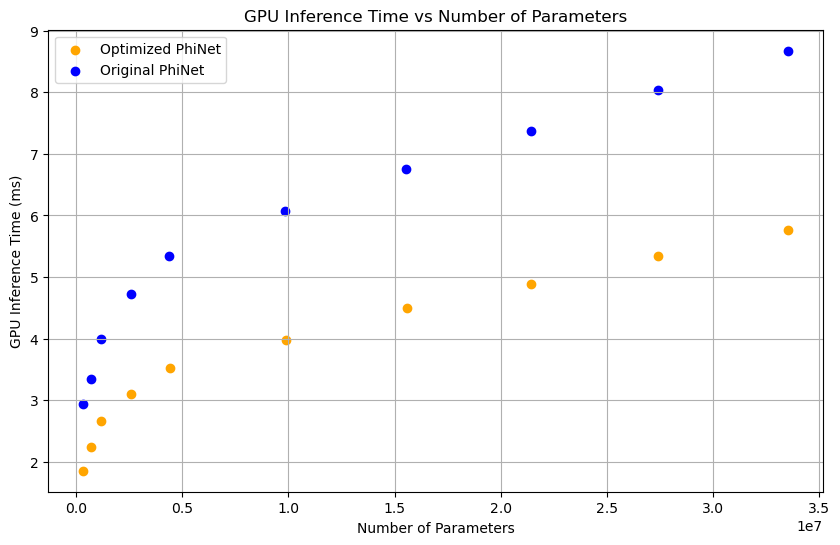

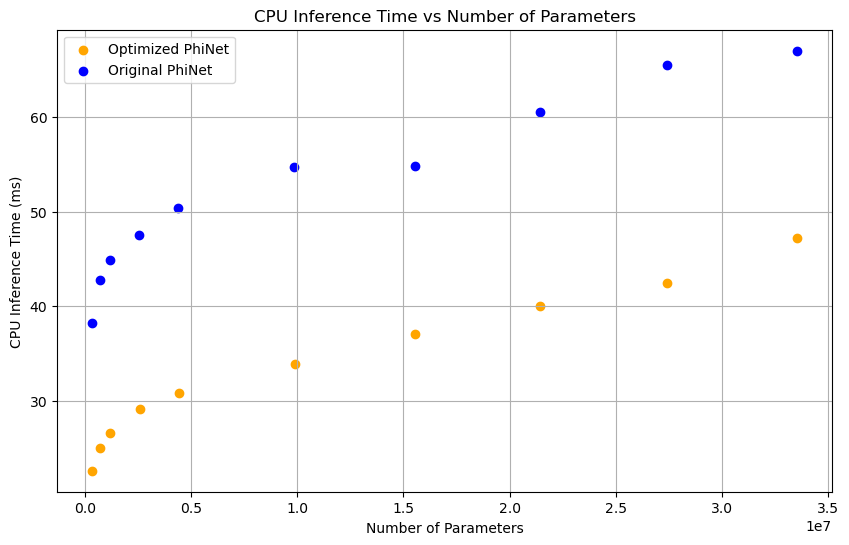

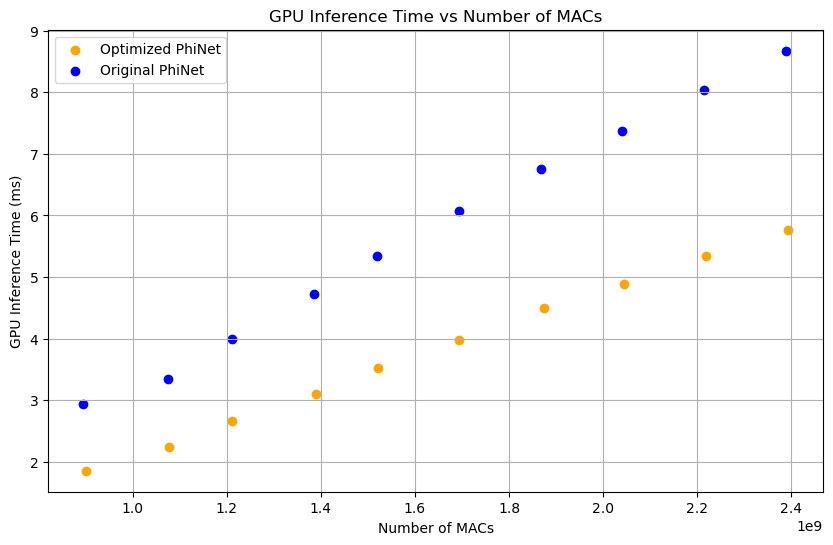

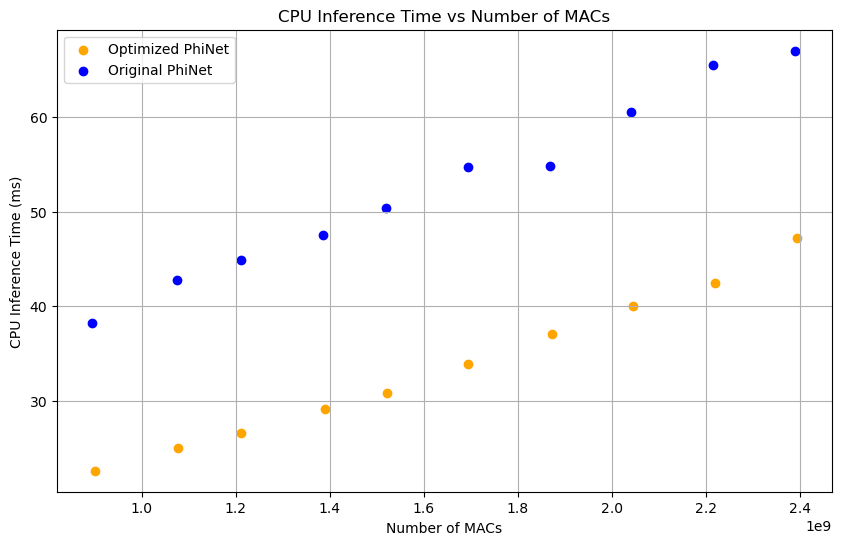

In [46]:
nr_layers = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

(opt_inference_time_list_GPU, opt_inference_time_list_CPU, opt_num_params_list, opt_num_macs_list,
 inference_time_list_GPU, inference_time_list_CPU, num_params_list, num_macs_list) = zip(*[get_inference_data(num_layers = layer) for layer in nr_layers])

# Plot inference_time_list_GPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_GPU, 
                                        num_params_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_CPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_CPU, 
                                        num_params_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_GPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_GPU, 
                                        num_macs_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of MACs"
)

# Plot inference_time_list_CPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_CPU, 
                                        num_macs_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of MACs"
)


## Alpha

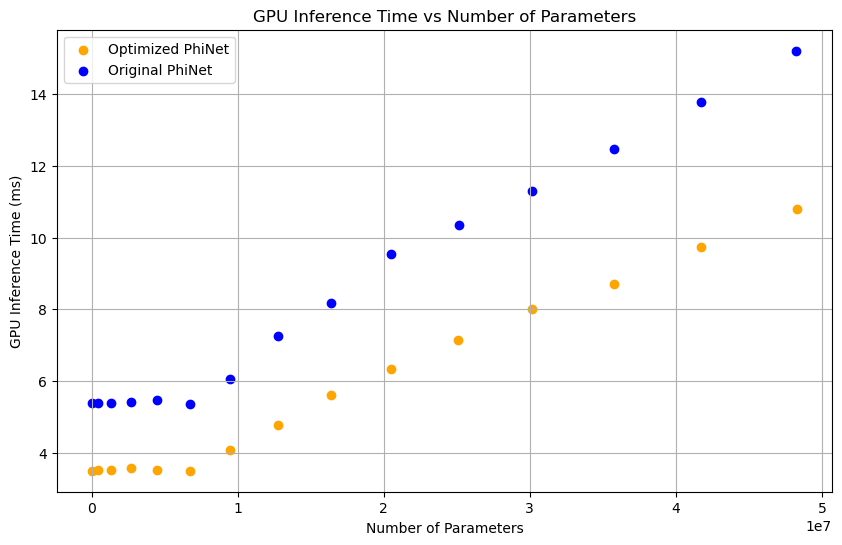

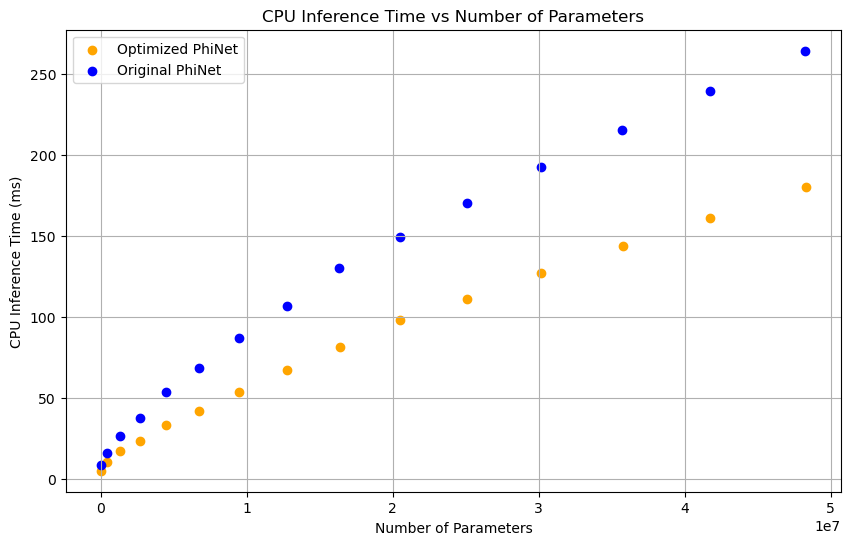

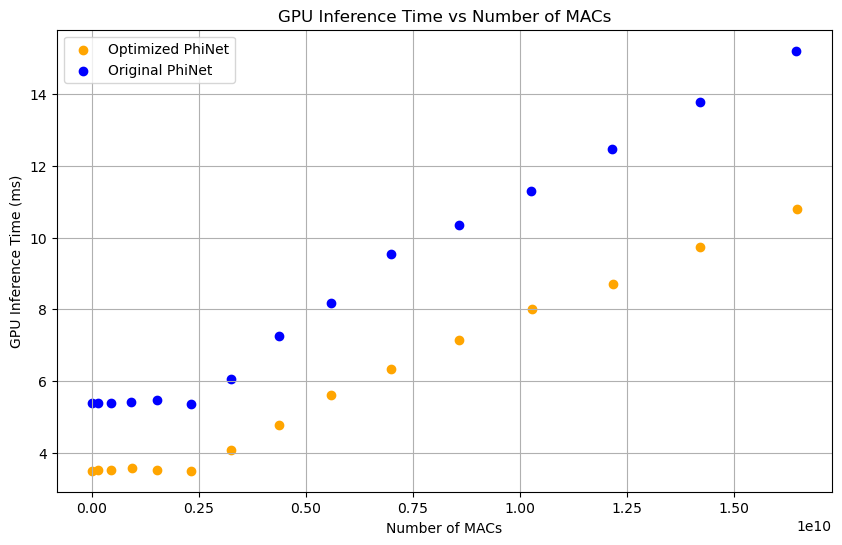

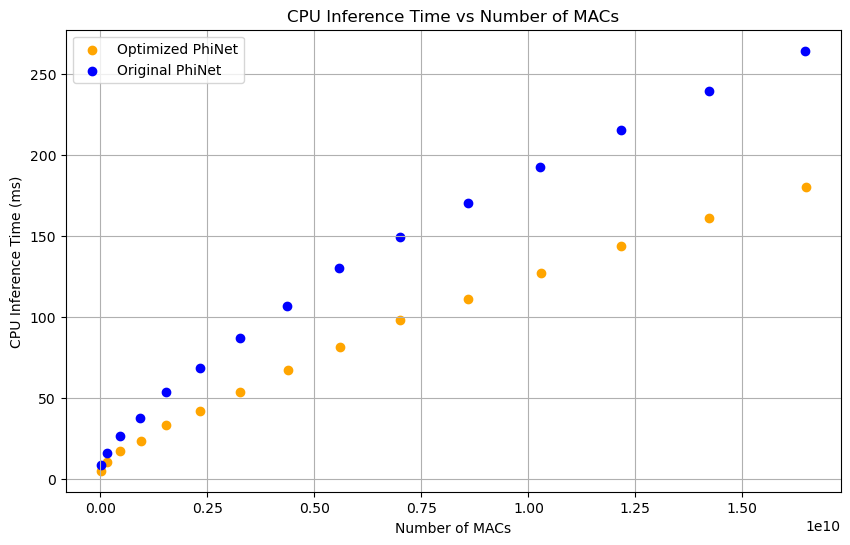

In [47]:
alphas = np.linspace(0.25, 10, 15)

(opt_inference_time_list_GPU, opt_inference_time_list_CPU, opt_num_params_list, opt_num_macs_list,
 inference_time_list_GPU, inference_time_list_CPU, num_params_list, num_macs_list) = zip(*[get_inference_data(alpha = alpha) for alpha in alphas])

# Plot inference_time_list_GPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_GPU, 
                                        num_params_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_CPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_CPU, 
                                        num_params_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_GPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_GPU, 
                                        num_macs_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of MACs"
)

# Plot inference_time_list_CPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_CPU, 
                                        num_macs_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of MACs"
)


## Beta

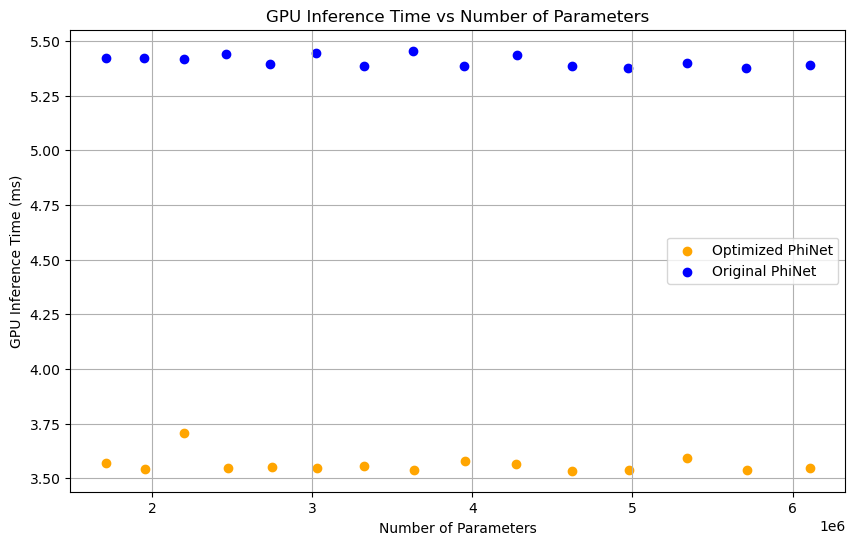

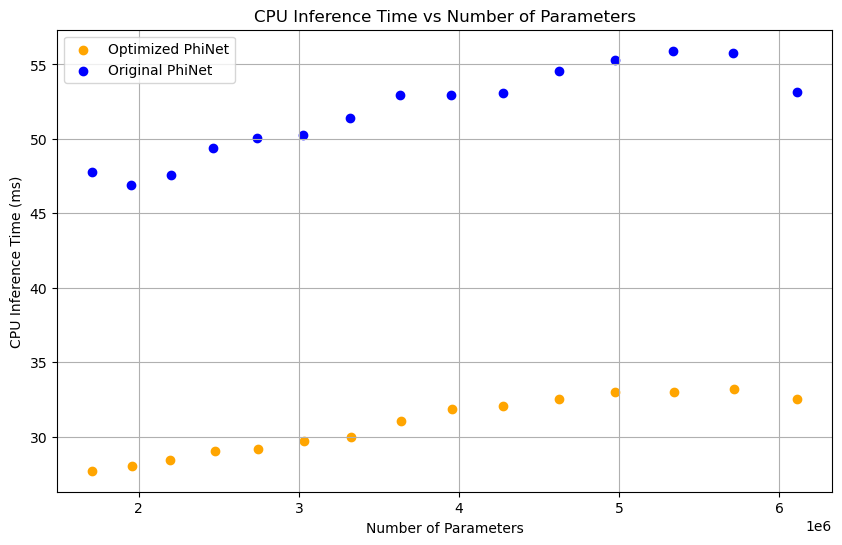

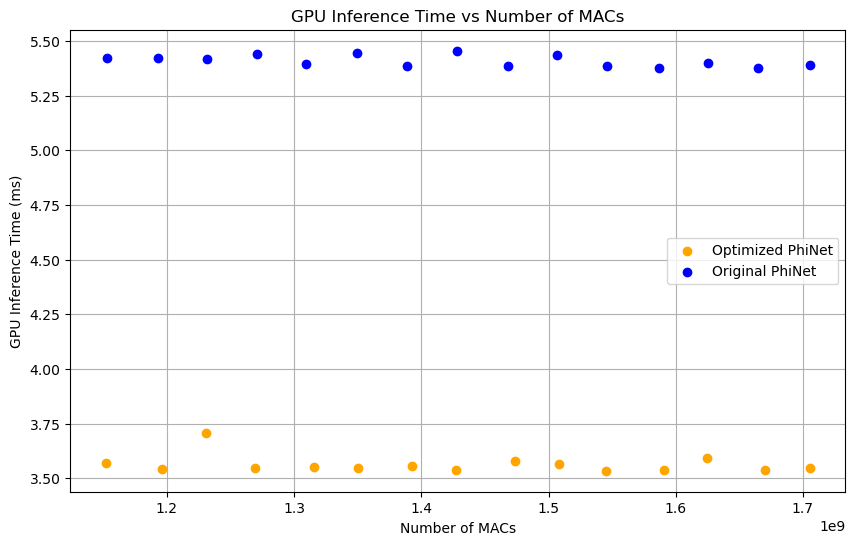

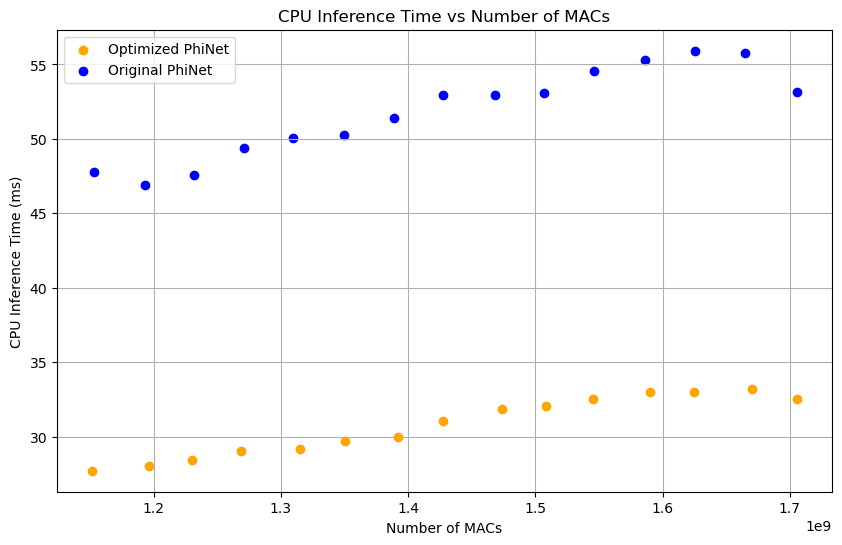

In [48]:
betas = np.linspace(0.25, 1, 15)

(opt_inference_time_list_GPU, opt_inference_time_list_CPU, opt_num_params_list, opt_num_macs_list,
 inference_time_list_GPU, inference_time_list_CPU, num_params_list, num_macs_list) = zip(*[get_inference_data(beta = beta) for beta in betas])

# Plot inference_time_list_GPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_GPU, 
                                        num_params_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_CPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_CPU, 
                                        num_params_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_GPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_GPU, 
                                        num_macs_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of MACs"
)

# Plot inference_time_list_CPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_CPU, 
                                        num_macs_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of MACs"
)


## t<sub>0</sub>

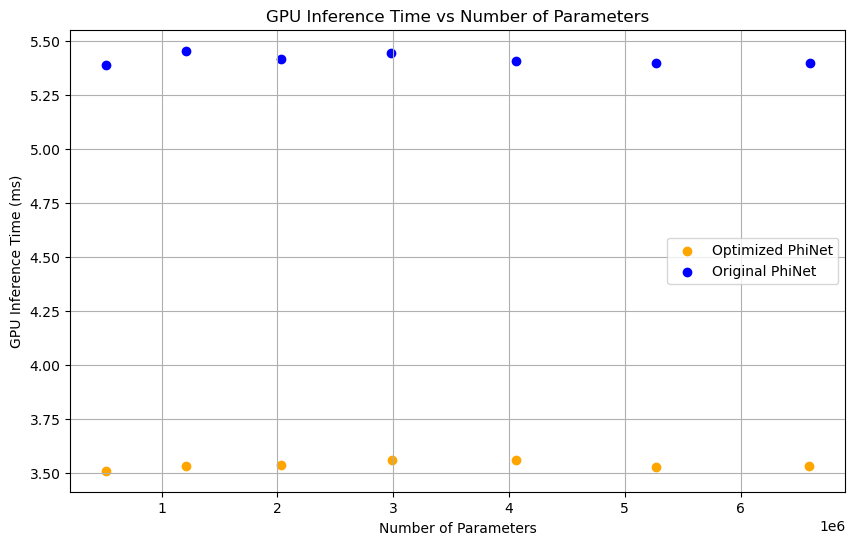

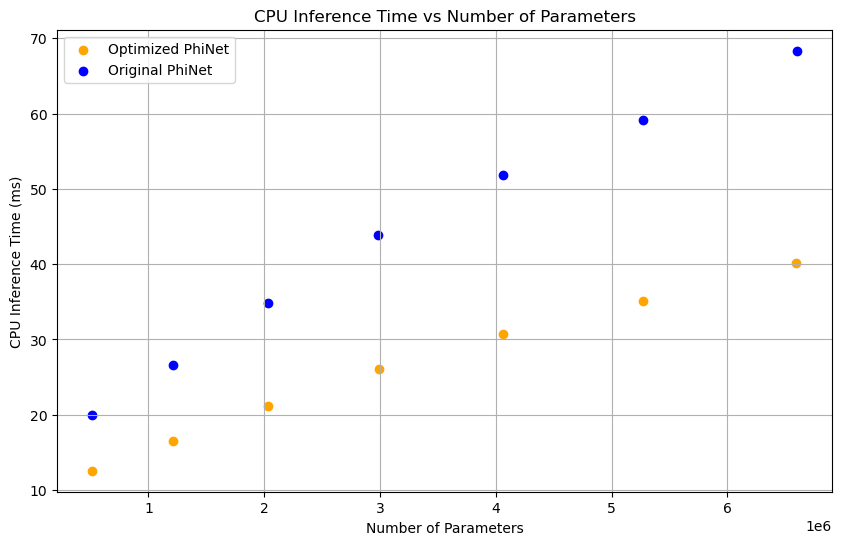

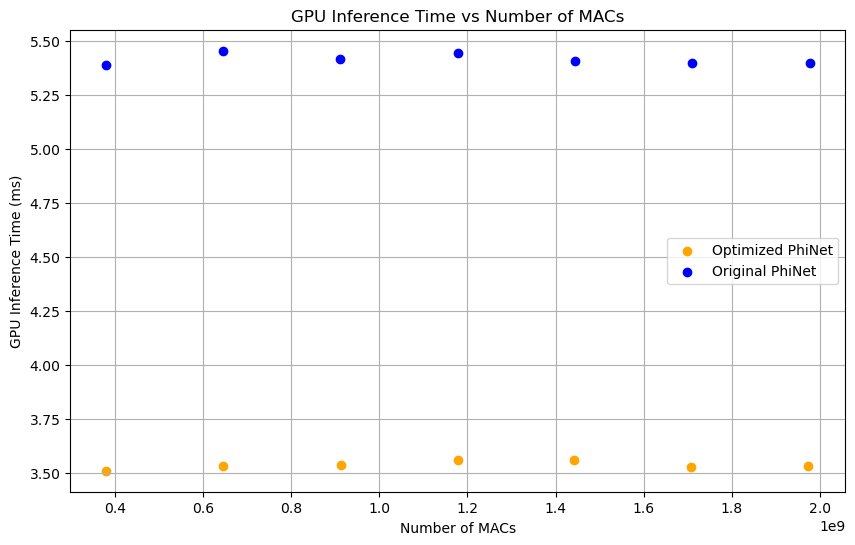

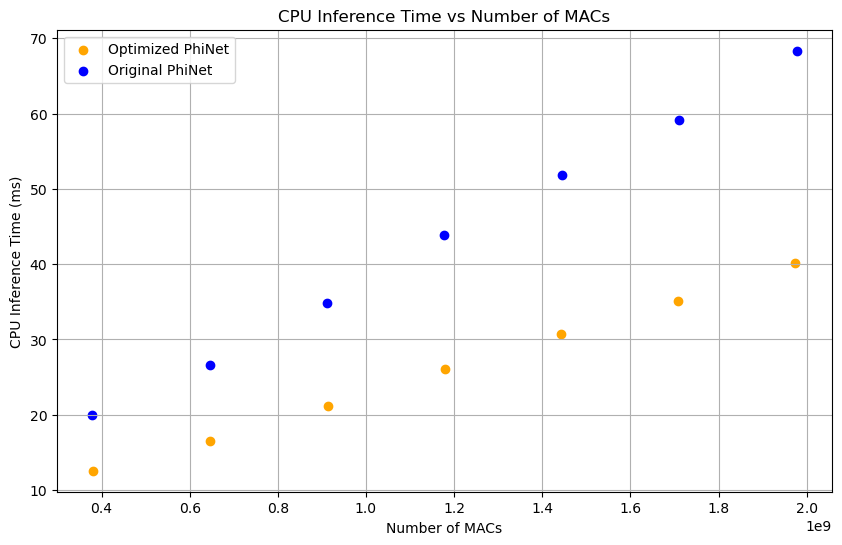

In [49]:
t_zeros = np.linspace(1, 8, 7)

(opt_inference_time_list_GPU, opt_inference_time_list_CPU, opt_num_params_list, opt_num_macs_list,
 inference_time_list_GPU, inference_time_list_CPU, num_params_list, num_macs_list) = zip(*[get_inference_data(t_zero= t_zero) for t_zero in t_zeros])

# Plot inference_time_list_GPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_GPU, 
                                        num_params_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_CPU vs num_params_list
plot(opt_num_params_list, 
                                        opt_inference_time_list_CPU, 
                                        num_params_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of Parameters", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of Parameters"
)

# Plot inference_time_list_GPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_GPU, 
                                        num_macs_list,
                                        inference_time_list_GPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "GPU Inference Time (ms)", 
                                        "GPU Inference Time vs Number of MACs"
)

# Plot inference_time_list_CPU vs num_macs_list
plot(opt_num_macs_list, 
                                        opt_inference_time_list_CPU, 
                                        num_macs_list,
                                        inference_time_list_CPU,                                        
                                        "Optimized PhiNet", 
                                        "Original PhiNet",
                                        "Number of MACs", 
                                        "CPU Inference Time (ms)", 
                                        "CPU Inference Time vs Number of MACs"
)


# Quantization Aware Training

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os

In [51]:
# Training Function
def train(model, train_loader, device, learning_rate=1e-1, num_epochs=200, save_dir="saved_models"):
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    tot_exp_time = 0

    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        train_loss = 0.0
        correct = 0
        total = 0

        # Initialize the timer
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        # Start Recording the time
        starter.record()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            prob = nn.functional.softmax(outputs, dim=1)
            _, predicted = prob.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)

        # Save the model state dictionary at the end of each epoch
        model_save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), model_save_path)

        # Save some statics the be saved in output
        tot_exp_time += curr_time
        accuracy = 100.0 * correct / total
        average_loss = train_loss / len(train_loader)

        print(f"Epoch {epoch+1}/{num_epochs} : Train accuracy {accuracy:.2f}%, Train loss {average_loss:.4f}, Training Time: {curr_time/1000:.3f} s")

    return model, tot_exp_time

def test(model, test_loader, device, criterion= nn.CrossEntropyLoss()):

    model.eval()
    model.to(device)

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            prob = nn.functional.softmax(outputs, dim=1)
            _, predicted = prob.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

def calibrate_model(model, loader, device=torch.device("cpu")):

    model.to(device)
    model.eval()

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        _ = model(inputs)

## MNIST

In [52]:
num_layers = 7 #4
alpha = 3 # 0.5
beta = 0.75 # 1
t_zero = 6 # 6

Download the MNIST dataset:

In [53]:
def prepare_dataloader(num_workers=1, train_batch_size=128, eval_batch_size=256):

    train_transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.1307,), std = (0.3081,))
        ]
    )

    train_set = torchvision.datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, transform=train_transform)


    train_sampler = torch.utils.data.RandomSampler(train_set)
    test_sampler = torch.utils.data.SequentialSampler(test_set)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=train_batch_size,
        sampler=train_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=eval_batch_size,
        sampler=test_sampler, num_workers=num_workers)

    return train_loader, test_loader

Training of the original PhiNet model on the MNIST dataset:

In [54]:
from micromind import PhiNet

set_random_seeds(random_seed=1)

model_mnist_fp32 = PhiNet(input_shape = [1, 28, 28], num_layers = num_layers, alpha = alpha, beta = beta, t_zero = t_zero, include_top = True, num_classes = 10)
print(model_mnist_fp32)

train_loader, test_loader = prepare_dataloader(num_workers=1, train_batch_size=128, eval_batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mnist_fp32, train_time_model_mnist_fp32 = train(model_mnist_fp32, train_loader, device, learning_rate=0.01, num_epochs=10, save_dir="orignal_model")

acc_model_mnist_fp32, _ = test(model_mnist_fp32, test_loader, device)

print(f"Training Time: {train_time_model_mnist_fp32/1000:.3f} s")
print(f"Test Accuracy: {acc_model_mnist_fp32:.2f}%")

PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): Conv2d(1, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): DepthwiseConv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Conv2d(72, 41

Training of the modified PhiNet model on the MNIST dataset:

In [55]:
from phinet_quant import PhiNet

# set the seed for reproducibility
set_random_seeds(random_seed=1)

model_quant_mnist_fp32 = PhiNet(input_shape = [1, 28, 28], num_layers = num_layers, alpha = alpha, beta = beta, t_zero = t_zero, include_top = True, num_classes = 10)
remove_depthwise(model_quant_mnist_fp32)
print(model_quant_mnist_fp32)

train_loader, test_loader = prepare_dataloader(num_workers=1, train_batch_size=128, eval_batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_quant_mnist_fp32, train_time_model_quant_mnist_fp32 = train(model_quant_mnist_fp32, train_loader, device, learning_rate=0.01, num_epochs=10, save_dir="modified_model")

acc_model_quant_mnist_fp32, _ = test(model_quant_mnist_fp32, test_loader, device)

print(f"Training Time: {train_time_model_quant_mnist_fp32/1000:.3f} s")
print(f"Test Accuracy: {acc_model_quant_mnist_fp32:.2f}%")

PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): Conv2d(1, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Conv2d(72, 416, 

Static Quantization of the modified PhiNet:

In [56]:
class PhiNetQuant(nn.Module):
    def __init__(self, model_fp32):
        super(PhiNetQuant, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.ao.quantization.QuantStub()
        # FP32 model
        self.model_fp32 = model_fp32
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        
        return x

In [57]:
set_random_seeds(random_seed=1)

# Copy the pretrained model for static quantization
model_st_quant_mnist_fp32 = copy.deepcopy(model_quant_mnist_fp32)
model_st_quant_mnist_fp32.to("cpu")

# Create a copy of the model for fusion
model_st_quant_mnist_fp32_fused = copy.deepcopy(model_st_quant_mnist_fp32)

# Set the models to eval mode (important for fusion)
model_st_quant_mnist_fp32.eval()
model_st_quant_mnist_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet model
phinet_fuse_modules(model_st_quant_mnist_fp32_fused)

print(f"model_fp32:\n {model_st_quant_mnist_fp32}\n")
print(f"model_fp32_fused:\n {model_st_quant_mnist_fp32_fused}\n")

assert model_equivalence(model_1=model_st_quant_mnist_fp32, model_2=model_st_quant_mnist_fp32_fused, device="cpu", rtol=1e-03, atol=1e-06, num_tests=100, input_size=(1,1,28,28)), "Fused model is not equivalent to the original model!"

# Insert stubs
model_st_quant_mnist_int8 = PhiNetQuant(model_st_quant_mnist_fp32_fused)

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

model_st_quant_mnist_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(model_st_quant_mnist_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {model_st_quant_mnist_int8}\n")

# Calibrate the model
calibrate_model(model_st_quant_mnist_int8, train_loader, device="cpu")

# Convert the observed model to a quantized model.
model_st_quant_mnist_int8 = torch.ao.quantization.convert(model_st_quant_mnist_int8, inplace=True)

print(f"model_int8:\n {model_st_quant_mnist_int8}\n")

acc_model_st_quant_mnist_int8, _ = test(model_st_quant_mnist_int8, test_loader, "cpu")

print(f"Test Accuracy: {acc_model_st_quant_mnist_int8:.2f}%")

model_fp32:
 PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): Conv2d(1, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Con

/home/matteotremonti/anaconda3/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


model_int8:
 PhiNetQuant(
  (quant): Quantize(scale=tensor([0.0255]), zero_point=tensor([17]), dtype=torch.quint8)
  (model_fp32): PhiNet(
    (_layers): ModuleList(
      (0): ZeroPad2d((0, 1, 0, 1))
      (1): SeparableConv2d(
        (_layers): ModuleList(
          (0): QuantizedConv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), scale=0.06262142211198807, zero_point=19, bias=False)
          (1): QuantizedConv2d(1, 144, kernel_size=(1, 1), stride=(1, 1), scale=0.1245897114276886, zero_point=62)
          (2): Identity()
          (3): QuantizedHardswish()
        )
      )
      (2): PhiNetConvBlock(
        (_layers): ModuleList(
          (0): Dropout2d(p=0.05, inplace=False)
          (1): QuantizedConv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), scale=0.1341703236103058, zero_point=65, padding=(1, 1), groups=144)
          (2): Identity()
          (3): QuantizedHardswish()
          (4): QuantizedConv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), scale=0.11604767292737961, zer

Quantization awere training of the modified model on the MNIST:

In [58]:
from phinet_quant import PhiNet

set_random_seeds(random_seed=1)

model_qat_quant_mnist_fp32 = PhiNet(input_shape = [1, 28, 28], num_layers = num_layers, alpha = alpha, beta = beta, t_zero = t_zero, include_top = True, num_classes = 10)
remove_depthwise(model_qat_quant_mnist_fp32)

load_epoch = 2

if load_epoch is not None:
    saved_model_path = f"modified_model/model_epoch_{load_epoch}.pt" 
    checkpoint = torch.load(saved_model_path)
    model_qat_quant_mnist_fp32.load_state_dict(checkpoint)

model_qat_quant_mnist_fp32.to("cpu")

# Create a copy of the model for fusion
model_qat_quant_mnist_fp32_fused = copy.deepcopy(model_qat_quant_mnist_fp32)

# Set the models to eval mode (important for fusion)
model_qat_quant_mnist_fp32.eval()
model_qat_quant_mnist_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet model
phinet_fuse_modules(model_qat_quant_mnist_fp32_fused)

print(f"model_fp32:\n {model_qat_quant_mnist_fp32}\n")
print(f"model_fp32_fused:\n {model_qat_quant_mnist_fp32_fused}\n")

# Insert stubs ion the model and in the forward pass
model_qat_quant_mnist_int8 = PhiNetQuant(model_qat_quant_mnist_fp32_fused)

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

model_qat_quant_mnist_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare_qat(model_qat_quant_mnist_int8.train(), inplace=True)

print(f"After preparation, note fake-quantization modules:\n {model_qat_quant_mnist_int8}\n")

# Quantization awere training and calibrate the model
model_qat_quant_mnist_int8, train_time_model_qat_quant_mnist_int8 = train(model_qat_quant_mnist_int8, train_loader, device = "cuda", learning_rate=0.001, num_epochs=10, save_dir="qat_model")

model_qat_quant_mnist_int8.to("cpu")

# Convert the observed model to a quantized model.
model_qat_quant_mnist_int8 = torch.ao.quantization.convert(model_qat_quant_mnist_int8, inplace=True)

print(f"model_int8:\n {model_qat_quant_mnist_int8}\n")

acc_model_qat_quant_mnist_int8, _ = test(model_qat_quant_mnist_int8, test_loader, "cpu")

print(f"Training Time: {train_time_model_qat_quant_mnist_int8/1000:.3f} s")
print(f"Test Accuracy: {acc_model_qat_quant_mnist_int8:.2f}%")

model_fp32:
 PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): Conv2d(1, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): Hardswish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Con

Compare results on **MNIST**:
- Orginal model FP32;
- Modified model FP32;
- Static Quantization of the modified model INT8;
- Quantization aware training of the modified model INT8;

In [62]:
model_fp32_cpu_inference_latency  = measure_inference_latency(model_mnist_fp32, device="cpu", input_shape=(1, 28, 28))
model_fp32_gpu_inference_latency  = measure_inference_latency(model_mnist_fp32, device="cuda", input_shape=(1, 28, 28))

model_quant_fp32_cpu_inference_latency  = measure_inference_latency(model_quant_mnist_fp32, device="cpu", input_shape=(1, 28, 28))
model_quant_fp32_gpu_inference_latency  = measure_inference_latency(model_quant_mnist_fp32, device="cuda", input_shape=(1, 28, 28))

model_st_quant_int8_cpu_inference_latency  = measure_inference_latency(model_st_quant_mnist_int8, device="cpu", input_shape=(1, 28, 28))
model_qat_quant_int8_cpu_inference_latency  = measure_inference_latency(model_qat_quant_mnist_int8, device="cpu", input_shape=(1, 28, 28))

print("Orginal FP32 model CPU Inference Latency: {:.3f} ms".format(model_fp32_cpu_inference_latency[0]))
print("Orginal FP32 model GPU Inference Latency: {:.3f} ms".format(model_fp32_gpu_inference_latency[0]))
print("Orginal FP32 model test accuracy: {:.2f}%".format(acc_model_mnist_fp32))
print("Original FP32 model training time: {:.3f} s\n".format(train_time_model_mnist_fp32/1000))

print("Modified FP32 model CPU Inference Latency: {:.3f} ms".format(model_quant_fp32_cpu_inference_latency[0]))
print("Modified FP32 model GPU Inference Latency: {:.3f} ms".format(model_quant_fp32_gpu_inference_latency[0]))
print("Modified FP32 model test accuracy: {:.2f}%".format(acc_model_quant_mnist_fp32))
print("Modified FP32 model training time: {:.3f} s\n".format(train_time_model_quant_mnist_fp32/1000))

print("Modified INT8 model static quant CPU Inference Latency: {:.3f} ms".format(model_st_quant_int8_cpu_inference_latency[0]))
print("Modified INT8 model static quant test accuracy: {:.2f}%\n".format(acc_model_st_quant_mnist_int8))

print("Modified INT8 model QAT CPU Inference Latency: {:.3f} ms".format(model_qat_quant_int8_cpu_inference_latency[0]))
print("Modified INT8 model QAT test accuracy: {:.2f}%".format(acc_model_qat_quant_mnist_int8))
print("Modified INT8 model QAT training time: {:.3f} s\n".format(train_time_model_qat_quant_mnist_int8/1000))

Orginal FP32 model CPU Inference Latency: 7.562 ms
Orginal FP32 model GPU Inference Latency: 5.732 ms
Orginal FP32 model test accuracy: 98.68%
Original FP32 model training time: 189.723 s

Modified FP32 model CPU Inference Latency: 5.418 ms
Modified FP32 model GPU Inference Latency: 3.615 ms
Modified FP32 model test accuracy: 98.76%
Modified FP32 model training time: 150.760 s

Modified INT8 model static quant CPU Inference Latency: 3.382 ms
Modified INT8 model static quant test accuracy: 98.70%

Modified INT8 model QAT CPU Inference Latency: 3.366 ms
Modified INT8 model QAT test accuracy: 98.90%
Modified INT8 model QAT training time: 626.026 s



## CIFAR

Download the CIFAR10 dataset:

In [60]:
def prepare_dataloader(num_workers=1, train_batch_size=128, eval_batch_size=256):

    train_transform = transforms.Compose([
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, transform=train_transform)

    train_sampler = torch.utils.data.RandomSampler(train_set)
    test_sampler = torch.utils.data.SequentialSampler(test_set)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=train_batch_size,
        sampler=train_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=eval_batch_size,
        sampler=test_sampler, num_workers=num_workers)

    return train_loader, test_loader    

Training of the original PhiNet model on the CIFAR10 dataset:

In [63]:
from micromind import PhiNet

set_random_seeds(random_seed=1)

model_cifar_fp32 = PhiNet(input_shape = [3, 32, 32], num_layers = 7, alpha = 3, beta = 0.75, t_zero = 6, include_top = True, num_classes = 10)
print(model_cifar_fp32)

train_loader, test_loader = prepare_dataloader(num_workers=1, train_batch_size=128, eval_batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cifar_fp32, train_time_model_cifar_fp32 = train(model_cifar_fp32, train_loader, device, learning_rate=0.01, num_epochs=10, save_dir="orignal_model")

acc_model_cifar_fp32, _ = test(model_cifar_fp32, test_loader, device)

print(f"Training Time: {train_time_model_cifar_fp32/1000:.3f} s")
print(f"Test Accuracy: {acc_model_cifar_fp32:.2f}%")

PhiNet(
  (_layers): ModuleList(
    (0): ZeroPad2d((0, 1, 0, 1))
    (1): SeparableConv2d(
      (_layers): ModuleList(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
        (1): Conv2d(3, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
      )
    )
    (2): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Dropout2d(p=0.05, inplace=False)
        (1): DepthwiseConv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (2): BatchNorm2d(144, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
        (3): HSwish()
        (4): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(72, eps=0.001, momentum=0.999, affine=True, track_running_stats=True)
      )
    )
    (3): PhiNetConvBlock(
      (_layers): ModuleList(
        (0): Con

Training of the modified PhiNet model on the CIFAR10 dataset:

In [ ]:
from phinet_quant import PhiNet

# set the seed for reproducibility
set_random_seeds(random_seed=1)

model_quant_cifar_fp32 = PhiNet(input_shape = [3, 32, 32], num_layers = 7, alpha = 3, beta = 0.75, t_zero = 6, include_top = True, num_classes = 10)
remove_depthwise(model_quant_cifar_fp32)
print(model_quant_cifar_fp32)

train_loader, test_loader = prepare_dataloader(num_workers=1, train_batch_size=128, eval_batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_quant_cifar_fp32, train_time_model_quant_cifar_fp32 = train(model_quant_cifar_fp32, train_loader, device, learning_rate=0.01, num_epochs=10, save_dir="modified_model")

acc_model_quant_cifar_fp32, _ = test(model_quant_cifar_fp32, test_loader, device)

print(f"Training Time: {train_time_model_quant_cifar_fp32/1000:.3f} s")
print(f"Test Accuracy: {acc_model_quant_cifar_fp32:.2f}%")

Static Quantization of the modified PhiNet:

In [ ]:
class PhiNetQuant(nn.Module):
    def __init__(self, model_fp32):
        super(PhiNetQuant, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.ao.quantization.QuantStub()
        # FP32 model
        self.model_fp32 = model_fp32
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        
        return x

In [ ]:
set_random_seeds(random_seed=1)

# Copy the pretrained model for static quantization
model_st_quant_cifar_fp32 = copy.deepcopy(model_quant_cifar_fp32)
model_st_quant_cifar_fp32.to("cpu")

# Create a copy of the model for fusion
model_st_quant_cifar_fp32_fused = copy.deepcopy(model_st_quant_cifar_fp32)

# Set the models to eval mode (important for fusion)
model_st_quant_cifar_fp32.eval()
model_st_quant_cifar_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet model
phinet_fuse_modules(model_st_quant_cifar_fp32_fused)

print(f"model_fp32:\n {model_st_quant_cifar_fp32}\n")
print(f"model_fp32_fused:\n {model_st_quant_cifar_fp32_fused}\n")

assert model_equivalence(model_1=model_st_quant_cifar_fp32, model_2=model_st_quant_cifar_fp32_fused, device="cpu", rtol=1e-03, atol=1e-06, num_tests=100, input_size=(1,3,32,32)), "Fused model is not equivalent to the original model!"

# Insert stubs
model_st_quant_cifar_int8 = PhiNetQuant(model_st_quant_cifar_fp32_fused)

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

model_st_quant_cifar_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare(model_st_quant_cifar_int8, inplace=True)

print(f"After preparation, note fake-quantization modules:\n {model_st_quant_cifar_int8}\n")

# Calibrate the model
calibrate_model(model_st_quant_cifar_int8, train_loader, device="cpu")

# Convert the observed model to a quantized model.
model_st_quant_cifar_int8 = torch.ao.quantization.convert(model_st_quant_cifar_int8, inplace=True)

print(f"model_int8:\n {model_st_quant_cifar_int8}\n")

acc_model_st_quant_cifar_int8, _ = test(model_st_quant_cifar_int8, test_loader, "cpu")

print(f"Test Accuracy: {acc_model_st_quant_cifar_int8:.2f}%")

Quantization awere training of the modified model on the CIFAR10:

In [ ]:
from phinet_quant import PhiNet

set_random_seeds(random_seed=1)

model_qat_quant_cifar_fp32 = PhiNet(input_shape = [3, 32, 32], num_layers = 7, alpha = 3, beta = 0.75, t_zero = 6, include_top = True, num_classes = 10)
remove_depthwise(model_qat_quant_cifar_fp32)

load_epoch = 2

if load_epoch is not None:
    saved_model_path = f"modified_model/model_epoch_{load_epoch}.pt" 
    checkpoint = torch.load(saved_model_path)
    model_qat_quant_cifar_fp32.load_state_dict(checkpoint)

model_qat_quant_cifar_fp32.to("cpu")

# Create a copy of the model for fusion
model_qat_quant_cifar_fp32_fused = copy.deepcopy(model_qat_quant_cifar_fp32)

# Set the models to eval mode (important for fusion)
model_qat_quant_cifar_fp32.eval()
model_qat_quant_cifar_fp32_fused.eval()

# Fuse Conv, BN modules in the PhiNet model
phinet_fuse_modules(model_qat_quant_cifar_fp32_fused)

print(f"model_fp32:\n {model_qat_quant_cifar_fp32}\n")
print(f"model_fp32_fused:\n {model_qat_quant_cifar_fp32_fused}\n")

# Insert stubs ion the model and in the forward pass
model_qat_quant_cifar_int8 = PhiNetQuant(model_qat_quant_cifar_fp32_fused)

quantization_config = torch.ao.quantization.get_default_qconfig("x86")

model_qat_quant_cifar_int8.qconfig = quantization_config

# Prepare the model for static quantization. 
torch.ao.quantization.prepare_qat(model_qat_quant_cifar_int8.train(), inplace=True)

print(f"After preparation, note fake-quantization modules:\n {model_qat_quant_cifar_int8}\n")

# Quantization awere training and calibrate the model
model_qat_quant_cifar_int8, train_time_model_qat_quant_cifar_int8 = train(model_qat_quant_cifar_int8, train_loader, device = "cuda", learning_rate=0.001, num_epochs=10, save_dir="qat_model")

model_qat_quant_cifar_int8.to("cpu")

# Convert the observed model to a quantized model.
model_qat_quant_cifar_int8 = torch.ao.quantization.convert(model_qat_quant_cifar_int8, inplace=True)

print(f"model_int8:\n {model_qat_quant_cifar_int8}\n")

acc_model_qat_quant_cifar_int8, _ = test(model_qat_quant_cifar_int8, test_loader, "cpu")

print(f"Training Time: {train_time_model_qat_quant_cifar_int8/1000:.3f} s")
print(f"Test Accuracy: {acc_model_qat_quant_cifar_int8:.2f}%")

Compare results on **CIFAR10**:
- Orginal model FP32;
- Modified model FP32;
- Static Quantization of the modified model INT8;
- Quantization aware training of the modified model INT8;

In [ ]:
model_fp32_cpu_inference_latency  = measure_inference_latency(model_cifar_fp32, device="cpu", input_shape=(3, 32, 32))
model_fp32_gpu_inference_latency  = measure_inference_latency(model_cifar_fp32, device="cuda", input_shape=(3, 32, 32))

model_quant_fp32_cpu_inference_latency  = measure_inference_latency(model_quant_cifar_fp32, device="cpu", input_shape=(3, 32, 32))
model_quant_fp32_gpu_inference_latency  = measure_inference_latency(model_quant_cifar_fp32, device="cuda", input_shape=(3, 32, 32))

model_st_quant_int8_cpu_inference_latency  = measure_inference_latency(model_st_quant_cifar_int8, device="cpu", input_shape=(3, 32, 32))
model_qat_quant_int8_cpu_inference_latency  = measure_inference_latency(model_qat_quant_cifar_int8, device="cpu", input_shape=(3, 32, 32))

print("Original FP32 model CPU Inference Latency: {:.3f} ms".format(model_fp32_cpu_inference_latency[0]))
print("Original FP32 model GPU Inference Latency: {:.3f} ms".format(model_fp32_gpu_inference_latency[0]))
print("Original FP32 model test accuracy: {:.2f}%".format(acc_model_cifar_fp32))
print("Original FP32 model training time: {:.3f} s\n".format(train_time_model_cifar_fp32/1000))

print("Modified FP32 model CPU Inference Latency: {:.3f} ms".format(model_quant_fp32_cpu_inference_latency[0]))
print("Modified FP32 model GPU Inference Latency: {:.3f} ms".format(model_quant_fp32_gpu_inference_latency[0]))
print("Modified FP32 model test accuracy: {:.2f}%".format(acc_model_quant_cifar_fp32))
print("Modified FP32 model training time: {:.3f} s\n".format(train_time_model_quant_cifar_fp32/1000))

print("Modified INT8 model static quant CPU Inference Latency: {:.3f} ms".format(model_st_quant_int8_cpu_inference_latency[0]))
print("Modified INT8 model static quant test accuracy: {:.2f}%\n".format(acc_model_st_quant_cifar_int8))

print("Modified INT8 model QAT CPU Inference Latency: {:.3f} ms".format(model_qat_quant_int8_cpu_inference_latency[0]))
print("Modified INT8 model QAT test accuracy: {:.2f}%".format(acc_model_qat_quant_cifar_int8))
print("Modified INT8 model QAT training time: {:.3f} s\n".format(train_time_model_qat_quant_cifar_int8/1000))